In [5]:
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [4]:
training_output = '/storage/brno2/home/david_pilny/Training_Output/'
training_id = '20230326'

def multi_unet_model(n_classes=4, IMG_HEIGHT=544, IMG_WIDTH=544, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
     
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    #Expansive path
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
     
    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

SIZE_X = 544
SIZE_Y = 544
n_classes = 4

input_dir = "../Dataset/images/"
mask_dir = "../Dataset/labels/"

train_images = []
for directory_path in sorted(os.listdir(input_dir)):
    input_path = input_dir + directory_path
    img = cv2.imread(input_path, 0)
    train_images.append(img)       
train_images = np.array(train_images)
print(train_images.shape)

train_masks = []
for directory_path in sorted(os.listdir(mask_dir)):
    input_path = mask_dir + directory_path
    mask = cv2.imread(input_path, 0)
    train_masks.append(mask)
train_masks = np.array(train_masks)
print(train_masks.shape)

labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_reshaped_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_reshaped_encoded_original_shape)

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks, axis=3)

X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state=42)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print("Class values in the dataset are ...", np.unique(y_train))

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded)
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

(869, 544, 544)
(869, 544, 544)


/Users/davidpilny/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class values in the dataset are ... [0 1 2 3]


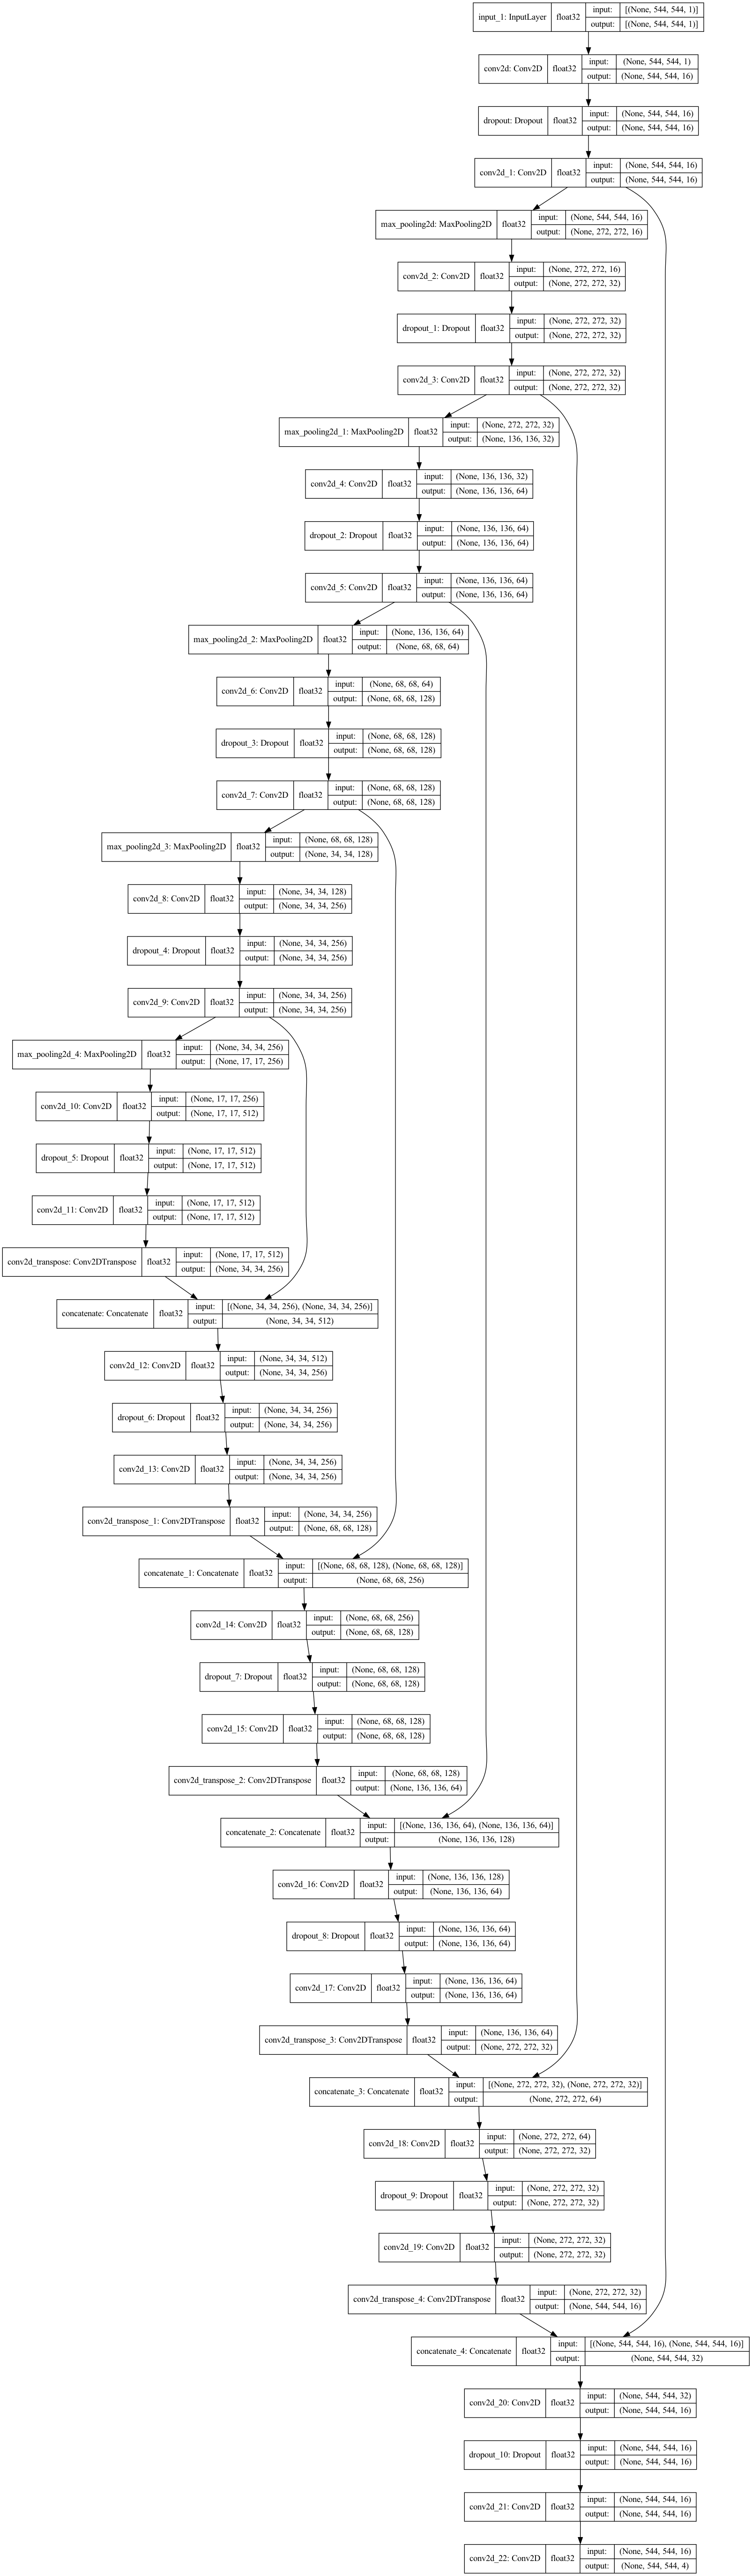

In [7]:
model_img_file = 'model-11.png'
plot_model(model, to_file=model_img_file, 
                          show_shapes=True, 
                          show_dtype=True,
                          show_layer_names=True )

In [15]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=30, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] = stringlist[-4]+" \hline"
    stringlist[-3] = stringlist[-3]+" \\\\"
    stringlist[-2] = stringlist[-2]+" \\\\"
    stringlist[-1] = stringlist[-1]+" \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{Model summary for test.}", "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)

In [16]:
m2tex(model)

NameError: name 'out_str' is not defined

In [14]:
f = open("summary.txt", "a")
f.write(model.summary())
f.close()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 544, 544, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 544, 544, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 544, 544, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 544, 544, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

TypeError: write() argument must be str, not None